# BU MET CS 767 Assignment 4 Part 2: GANs
*Alessandro Allegranzi*

*06/05/2024*

## Loading a subset of the Kaggle CelebA Dataset https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64

In [ ]:
# The below commands download the whole data set, which is large.
# If you want to DL data uncomment the below.
# !pip install -q kaggle
# from google.colab import userdata
# import os

# os.environ["KAGGLE_KEY"] = userdata.get('key')
# os.environ["KAGGLE_USERNAME"] = userdata.get('user_name')

# DLing a 50k subset of the celebA dataset formatted to 64x64 images
# For this assignment I actually further cut it down to about 10k to make
# the data size more manageable.
# !kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

# !unzip 50k-celeba-dataset-64x64.zip -d /content/drive/MyDrive/Colab\ Notebooks/data


In [ ]:
# Standard Imports

import tensorflow as tf

# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

# For Gaussian Weight Stabilization
from keras.initializers import RandomNormal

from IPython import display

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

# Constants
BATCH_SIZE = 128

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-idd2806p
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-idd2806p
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=ea745f129a3ad31b31f00fe608339eb2df0ddbdd75ed3636b3070965f0f6b746
  Stored in directory: /tmp/pip-ephem-wheel-cache-kvnumgz3/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Format the Data

In [ ]:
# Directory where the images are located
dir = '/content/drive/MyDrive/Colab Notebooks/data/50k/'

# Let's make sure we have data.
print(len(os.listdir(dir)))
print(os.listdir(dir)[:10])

# Create a dataset
file_paths = glob.glob(dir + '/*.jpg')
dataset = tf.data.Dataset.from_tensor_slices(file_paths)

# Function to load and preprocess an image
def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Images should already be 64x64 but just to be safe.
    img = tf.image.resize(img, [64, 64])
    # Normalize pixel values to [0,1]
    img = img / 255.0
    return img

# Apply the function to each item in the dataset
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.take(3000) #limiting the dataset size otherwise epochs take too long to run
dataset = dataset.batch(BATCH_SIZE)

10506
['033506.jpg', '031470.jpg', '032049.jpg', '032667.jpg', '032878.jpg', '031216.jpg', '031803.jpg', '031675.jpg', '034103.jpg', '033638.jpg']


## Confirming we have a dataset of images.

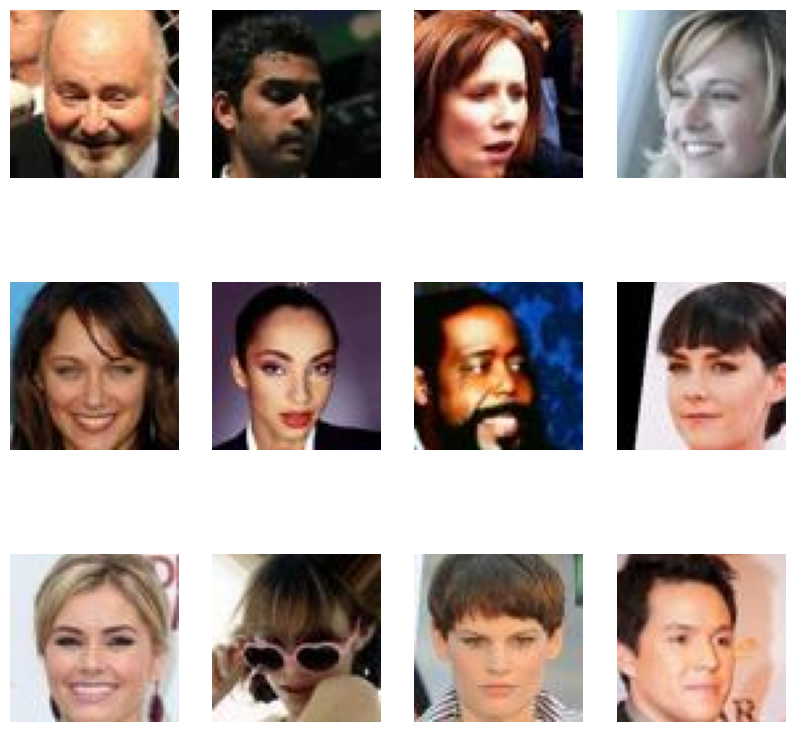

In [ ]:
# Take sample of the first 12 from the dataset
# images = next(iter(dataset.batch(12)))

# Take the first batch
first_batch = next(iter(dataset))

# Select the first 12 images from the batch
images = first_batch[:12]

# Create a grid of images
fig, axes = plt.subplots(3, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')

plt.show()

## Create the Models

This model takes a 100-dimensional noise vector as input and produces a 64x64 RGB image as output. The Conv2DTranspose layers perform the upsampling, and the BatchNormalization and LeakyReLU layers help to stabilize the training.

The output layer uses a tanh activation function, so the pixel values of the generated images will be in the range [-1,1]. If your real images have pixel values in the range [0,1], you should adjust the preprocessing of the real images and the postprocessing of the generated images accordingly.

In [ ]:
# Generator Model

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

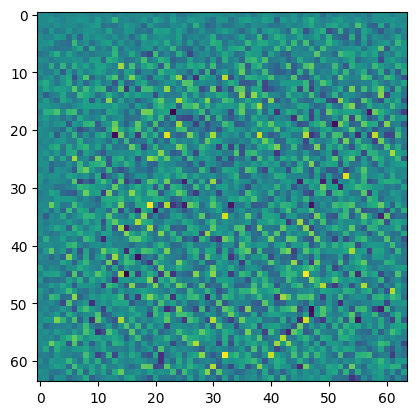

In [ ]:
# Printing a generated image pre-training.

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

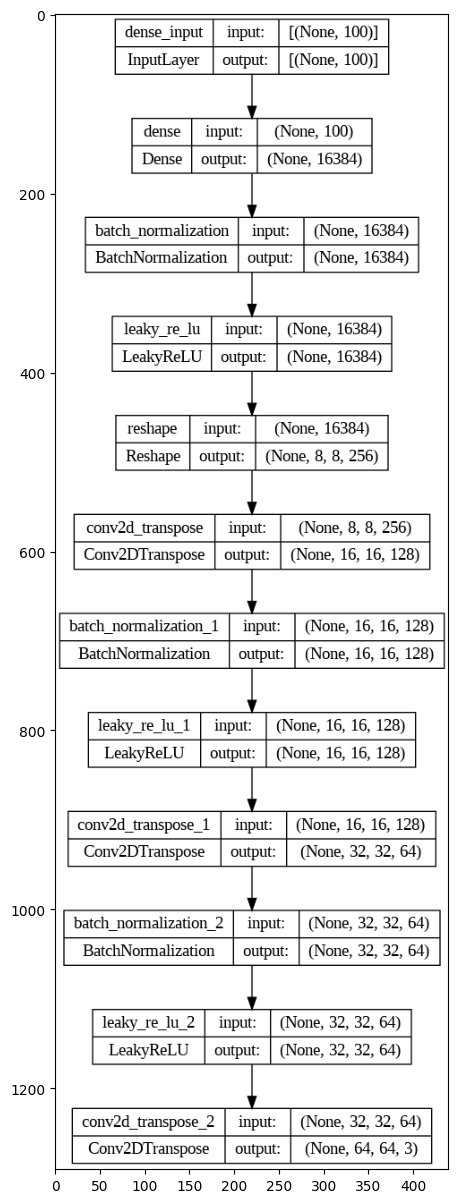

In [ ]:
file_name = './generator_layers.png'
# Generate the plot
plot_model(generator, to_file=file_name, show_shapes=True, show_layer_names=True)

# Show the plot here
img = mpimg.imread(file_name)
plt.figure(figsize=(30,15))
imgplot = plt.imshow(img)
plt.show()

The model is a sequential convolutional neural network (CNN) discriminator model for a Generative Adversarial Network (GAN). It consists of three convolutional layers, each followed by a LeakyReLU activation and a dropout layer, and ends with a flattening layer and a dense layer with a single output.

In [ ]:
# Discriminator

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00090041]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)        

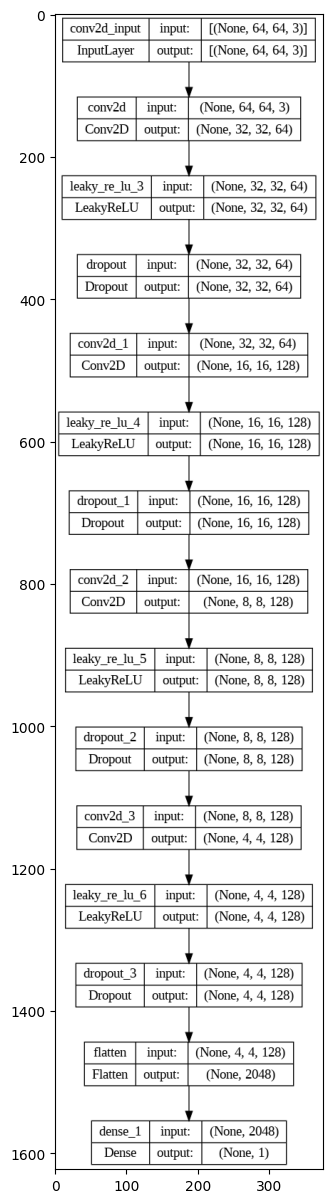

In [ ]:
file_name = './discriminator_layers.png'
# Generate the plot
plot_model(discriminator, to_file=file_name, show_shapes=True, show_layer_names=True)

# Show the plot here
img = mpimg.imread(file_name)
plt.figure(figsize=(30,15))
imgplot = plt.imshow(img)
plt.show()

## Loss and Optimizers

The below optimizers and train functions are based on those from the part 1 notebook of the assignment. https://colab.research.google.com/drive/1EC-D9CbVfe6oMPqFNqQ1uDcp2QYHqLZC?usp=sharing

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Using Adam version of stochastic gradient descent with the learning rate of 0.0002
# and the beta1 momentum value of 0.5 instead of the default of 0.9.
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
# Saving checkpoints like in part 1. Seems like a good idea.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed over time (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# `tf.function` causes the function to be "compiled".
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # Use all three channels to display the color image
      plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype("uint8"))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

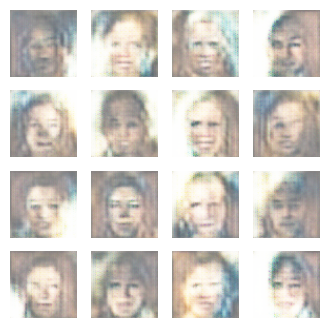

In [ ]:
train(dataset, EPOCHS)

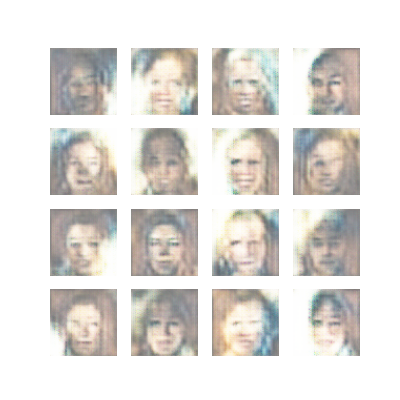

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

## Creating a gif of generated images like in Assignment part 1

In [ ]:
anim_file = 'celeb_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-23-d1c5fc067d78>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-23-d1c5fc067d78>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



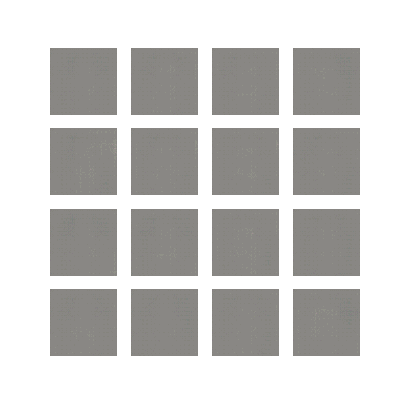

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)